# Processing of DIC data using numpy/scipy

Enable plotting using the `widget` front-end of matplotlib and import numpy and matplotlib packages as `np` and `plt`.

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
import pandas as pd

Import the regular grid interpolator

In [3]:
from scipy.interpolate import LinearNDInterpolator
from scipy.spatial import Delaunay

In [4]:
import os.path as op
import os

## Read the history of displacements and strains

In [5]:
base_dir = op.expanduser('~')
base_dir = op.join('C:\\', '97_jupyter', 'prestressed_beam')
data_dir_name = 'S0_epsX'
time_F_dic_file_name = 'V2.csv'
data_path = op.join(base_dir, 'serie_0')
csv_data_dir = op.join(data_path, data_dir_name)
time_F_dic_file = op.join(data_path, time_F_dic_file_name)
npz_file = op.join(data_path, 'S16.npz')

In [ ]:
base_dir = op.expanduser('~')
base_dir = op.join('C:\\', '97_jupyter', 'dic_jupyter_tutorial')
data_dir_name = 'S16_01_epsX'
time_F_dic_file_name = 'S16-1_Kraft.csv'
data_path = op.join(base_dir, 'S16')
csv_data_dir = op.join(data_path, data_dir_name)
time_F_dic_file = op.join(data_path, time_F_dic_file_name)
npz_file = op.join(data_path, 'S16.npz')

In [13]:
# base_dir = op.join('/fileserver', '97_jupyter', 'dic_jupyter_tutorial')
# data_dir_name = 'S16_01_epsX'
# time_F_dic_file_name = 'S16-1_Kraft.csv'
# data_path = op.join(base_dir, 'S16')
# csv_data_dir = op.join(data_path, data_dir_name)
# time_F_dic_file = op.join(data_path, time_F_dic_file_name)
# npz_file = op.join(data_path, 'S16.npz')
# npz_file

In [6]:
data = np.load(npz_file)

In [7]:
X_0Qa, U_TQa = data['X_0Qa'], data['U_TQa']
U_TQa.shape

(2417, 21239, 3)

In [8]:
n_T = len(U_TQa)

In [9]:
X_0Qa.shape, U_TQa.shape, (X_0Qa + U_TQa[1]).shape

((21239, 3), (2417, 21239, 3), (21239, 3))

### Displacement at nodes

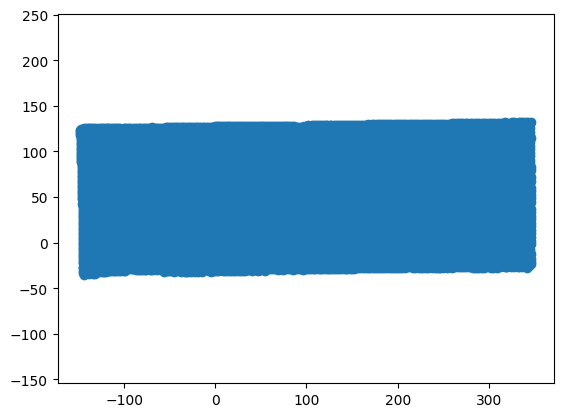

In [11]:
fig = plt.figure()
ax = fig.add_subplot()
T = 20
U_factor = 100
X_scaled_Qa = X_0Qa + U_factor * U_TQa[T]
args = (X_scaled_Qa[:, 0], X_scaled_Qa[:, 1])
ax.scatter(*args);
ax.axis('equal');
# ax.set_xlim(200,205)
# ax.set_ylim(-100,-105)

In [12]:
points = X_0Qa[:, :-1]
delauney = Delaunay(points)

## Displacement interpolation grid to calculate strains

The monitored area is not rectangular and not aligned with the camera configuration. Therefore, we introduce padding which cu

In [22]:
pad_b, pad_t, pad_r, pad_l = 10, 10, 100, 100

In [23]:
np.min(X_0Qa, axis=0)

array([-247.7939,  -83.0458,  -41.3066])

In [24]:
X_outer_frame = np.min(X_0Qa, axis=0), np.max(X_0Qa, axis=0)
X_outer_frame

(array([-247.7939,  -83.0458,  -41.3066]),
 array([249.7419,  78.6209,  42.2732]))

In [25]:
n_a = 2

### Interpolation grid

In [26]:
X_min_a, X_max_a = X_outer_frame
L_a = X_max_a - X_min_a # frame dimensions
d = 4 # 4 mm distances
n_a = 2 # number of spatial dimensions
n_I, n_J = np.array( L_a[:-1] / d, dtype=np.int_ )
d_X_a = [L_a[0]/n_I, L_a[1]/n_J]
n_I, n_J, L_a

(124, 40, array([497.5358, 161.6667,  83.5798]))

In [27]:
min_x, min_y, _ = X_min_a
max_x, max_y, _ = X_max_a
X_aIJ = np.mgrid[
        min_x + pad_l:max_x - pad_r:complex(n_I),
        min_y + pad_b:max_y - pad_t:complex(n_J)]
x_IJ, y_IJ = X_aIJ
X0_IJa = np.einsum('aIJ->IJa', np.array([x_IJ, y_IJ]))
X_min_a, X_max_a

(array([-247.7939,  -83.0458,  -41.3066]),
 array([249.7419,  78.6209,  42.2732]))

In [28]:
max_x - pad_r

149.7419

In [29]:
x0_IJ, y0_IJ = np.einsum('IJa->aIJ', X0_IJa)
U_IJa_list = []
for T in range(n_T):
    values = U_TQa[T, :, :]
    get_U = LinearNDInterpolator(delauney, values)
    U_IJa = get_U(x0_IJ, y0_IJ)
    U_IJa_list.append(U_IJa)
U_TIJa = np.array(U_IJa_list)[...,:-1]

## Strain field history

The following five cells deliver the derivatives in the quadrature points

In [30]:
I,J,a = [np.arange(n) for n in (n_I,n_J,n_a)]
G_aIJ = (np.einsum('a, I->aI', (1-a), I)[:,:, None] + 
         np.einsum('a, J->aJ', a, J)[:,None, :])

In [31]:
n_i, n_j = 2, 2
g_aij = G_aIJ[:,:n_i,:n_j]
n_E, n_F = n_I-1, n_J-1
G_aEF = G_aIJ[:,:-1,:-1]
H_aEiFj = G_aEF[:,:,None,:,None] + g_aij[:,None,:,None,:]
X_EiFja = X0_IJa[(*H_aEiFj,)]
U_TEiFja = U_TIJa[(slice(None), *H_aEiFj)]

In [32]:
delta_rs = np.eye(2, dtype=np.int_)
xi_rij = (H_aEiFj[:,0,:,0,:] * 2) - 1
n_m, n_n = n_i, n_j
eta_rmn = 3**(-1/2) * xi_rij
N_ijmn = (1 + 
  np.einsum('rmn,rij->ijmn', eta_rmn, xi_rij) +
  np.einsum('rs,smn,sij,rmn,rij->ijmn', (1-delta_rs), eta_rmn, xi_rij, eta_rmn, xi_rij) / 2
)/4

In [33]:
dN_sijmn = (
    xi_rij[:,:,:,None,None] + 
    np.einsum('rs,sij,rmn,rij->sijmn', (1 - delta_rs), xi_rij, eta_rmn, xi_rij)
) / 4
J_EmFnas = np.einsum(
 'sijmn,EiFja->EmFnas',
 dN_sijmn, X_EiFja
)
inv_J_EmFnsa = np.linalg.inv(J_EmFnas)

In [34]:
delta_ab = np.eye(2)
Diff1_abcd = 0.5 * (
    np.einsum('ac,bd->abcd', delta_ab, delta_ab) +
    np.einsum('ad,bc->abcd', delta_ab, delta_ab)
)
B_EiFjmnabc = np.einsum(
    'abcd,sijmn,EmFnsd->EiFjmnabc',
    Diff1_abcd, dN_sijmn, inv_J_EmFnsa
)

In [35]:
eps_TEmFnab = np.einsum(
    'EiFjmnabc,TEiFjc->TEmFnab',
    B_EiFjmnabc, U_TEiFja
)
eps_TEmFnab.shape

(2417, 123, 2, 39, 2, 2, 2)

## Export the data to paraview

In [44]:
X_aEmFn = np.einsum('ijmn,EiFja->aEmFn', N_ijmn, X_EiFja)
X_aKL = X_aEmFn.reshape(-1,(n_I-1)*2, (n_J-1)*2)
X_KLa = np.einsum('aKL->KLa', X_aKL)

In [45]:
eps_TKLab = eps_TEmFnab.reshape(-1, n_E*n_m, n_F*n_n, 2, 2)
eps_TKxLab = eps_TEmFnab.reshape(-1, n_E*n_m*n_F*n_n, 2, 2)
eigenvalues = np.zeros((eps_TKLab.shape[0], eps_TKLab.shape[1]*eps_TKLab.shape[2], 2))

# for t in range(eps_TKLab.shape[0]):
#     # Iterate over each point
#     for i in range(eps_TKLab.shape[1]*eps_TKLab.shape[2]):
#         # Get the strain tensor at time t for point i
#         strain_tensor_point = eps_TKxLab[t, i]
#         # Compute the eigenvalues
#         eigenvalues[t, i] = np.linalg.eigvals(strain_tensor_point)

In [47]:
eigenvalues.shape

(2417, 19188, 2)

In [48]:
from pyevtk.hl import gridToVTK, unstructuredGridToVTK, pointsToVTK

# assuming you have eps_TKLab, X_KLa variables defined
# get the time steps and the grid size
T, nx, ny, a, b = eps_TKLab.shape

eps3d_TKab = np.zeros((T, nx*ny, 3, 3), dtype=np.float_)
# get the grid coordinates
x = np.ascontiguousarray(X_KLa[:, :, 0].flatten())
y = np.ascontiguousarray(X_KLa[:, :, 1].flatten())
z = np.zeros_like(x)
connectivity = np.empty(0, dtype=np.int32)

# Calculate offsets array (only one element for a point cloud)
offsets = np.array([0], dtype=np.int32)

# Generate cell types array (empty for a point cloud)
cell_types = np.empty(0, dtype=np.uint8)

# Total number of cells (0 for a point cloud)
num_cells = 0
# x = np.linspace(0, 1, nx)
# y = np.linspace(0, 1, ny)
# z = np.zeros(1)


In [48]:
eps3d_TKab.shape

(2417, 19188, 3, 3)

In [49]:
# for each time step save a vtr file
for t in range(T):
    
    eps3d_TKab[t, :, :2, :2] = eps_TKxLab[t, ...]
    tensor_field = eps3d_TKab.reshape(-1, 3, 3)
    # get the tensor field at the current time step

    # create the path for the VTR file
    # FILE_PATH = f"./temp/tensor_field_{t}"
    FILE_PATH = f"C:/97_jupyter/prestressed_beam/serie_0/paraview/eps_xx_{t}"

    # export to VTR

    pointsToVTK(FILE_PATH, x, y, z,
              data = {"eps_xx" : np.ascontiguousarray(eps3d_TKab[t,:,0,0])})
    
#     FILE_PATH = f"E:/97_jupyter/VB1/paraview/eps_II_{t}"

#     pointsToVTK(FILE_PATH, x, y, z,
#               data = {"eps_II" : np.ascontiguousarray(eigenvalues[t,:,1])})
    

# MS1 evaluation

In [46]:
from ibvpy.tmodel.mats2D import \
    MATS2DElastic, MATS2DMplDamageEEQ, \
    MATS2DMplCSDEEQ, MATS2DScalarDamage
from bmcs_matmod.ms1.ms1 import MS13D
import bmcs_matmod.ms1.concrete_material_db as mp_db
import copy

In [37]:
eps_TKxLab.shape

(2417, 19188, 2, 2)

In [38]:
sig_TKab = np.zeros_like(eps_TKxLab)

In [39]:
concrete_type = 0  # 0:C40MA, 1:C80MA, 2:120MA, 3:Tensile, 4:Compressive, 5:Biaxial, 6:Confinement, 7:Sensitivity

#tmodel = MS13D(**mp_db.C40MS1)
tmodel = MATS2DMplCSDEEQ()

copy_state_arrays = {}
state_arrays = {}

for i in range(eps_TKxLab.shape[1]):
    copy_state_arrays[i] = {name: np.zeros(shape_, dtype=np.float_) for
                    name, shape_ in tmodel.state_var_shapes.items()}
    state_arrays[i] = {name: np.zeros(shape_, dtype=np.float_) for
                    name, shape_ in tmodel.state_var_shapes.items()}

In [40]:
for i in range(len(eps_TKxLab)):
    print(i)

    for point, state_array in copy_state_arrays.items():
        #print(eps_TKxLab[i][point].shape)
        D_abcd, sig_TKab[i][point] = tmodel.get_corr_pred(
            eps_TKxLab[i][point], 0, **state_array
        )
    copy_state_arrays = copy.copy(state_arrays)

0
1


c:\Users\marag\miniconda3\envs\bmcs_base\lib\site-packages\ibvpy\tmodel\mats2D\mats2D_microplane\vmats2D_mpl_csd_eeq.py:383: RuntimeWarning: invalid value encountered in sqrt
  phi_Emn = np.sqrt(1.0 - w_Emn)
c:\Users\marag\miniconda3\envs\bmcs_base\lib\site-packages\ibvpy\tmodel\mats2D\mats2D_microplane\vmats2D_mpl_csd_eeq.py:249: RuntimeWarning: invalid value encountered in power
  w_T_Emn += ((1 - w_T_Emn) ** self.c_T) * \


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
27

KeyboardInterrupt: 

In [42]:
sigma = sig_TKab[:1920]

In [49]:
# for each time step save a vtr file
sig3d_TKab = np.zeros((T, nx*ny, 3, 3), dtype=np.float_)
for t in range(T):
    
    sig3d_TKab[t, :, :2, :2] = sig_TKab[t, ...]
    tensor_field = sig3d_TKab.reshape(-1, 3, 3)
    # get the tensor field at the current time step

    # create the path for the VTR file
    # FILE_PATH = f"./temp/tensor_field_{t}"
    FILE_PATH = f"C:/97_jupyter/prestressed_beam/serie_0/paraview/sig_xx_{t}"

    # export to VTR

    pointsToVTK(FILE_PATH, x, y, z,
              data = {"sig_xx" : np.ascontiguousarray(sig3d_TKab[t,:,0,0])})
    
#     FILE_PATH = f"E:/97_jupyter/VB1/paraview/eps_II_{t}"

#     pointsToVTK(FILE_PATH, x, y, z,
#               data = {"eps_II" : np.ascontiguousarray(eigenvalues[t,:,1])})
    

In [ ]:
copy_state_arrays[500]

SyntaxError: invalid syntax (3558056877.py, line 1)

SyntaxError: invalid syntax (214292494.py, line 1)

In [56]:
import json
with open('C:/97_jupyter/prestressed_beam/serie_0/state_vars_dict.json', 'w') as f:
    json.dump(copy_state_arrays, f)

TypeError: Object of type ndarray is not JSON serializable

## Evaluation of damage

In [50]:
eps_TEmFna, _ = np.linalg.eig(eps_TEmFnab)

In [26]:
kappa_TEmFn = np.max(eps_TEmFna, axis=-1)
kappa_TKL = kappa_TEmFn.reshape(-1, n_E*n_m, n_F*n_n)
kappa_TKL[np.where(kappa_TKL<0)] = 0

In [27]:
eps_0=0.002
#eps_f=0.0028
eps_f=0.003

In [28]:
I = np.where(kappa_TEmFn>=eps_0)
omega_TEmFn = np.zeros_like(kappa_TEmFn)
omega_TEmFn[I] = 1.0-(eps_0/kappa_TEmFn[I]*np.exp(
    -(kappa_TEmFn[I]-eps_0)/(eps_f-eps_0))
)

In [29]:
omega_TKL = omega_TEmFn.reshape(-1, n_E*n_m, n_F*n_n)

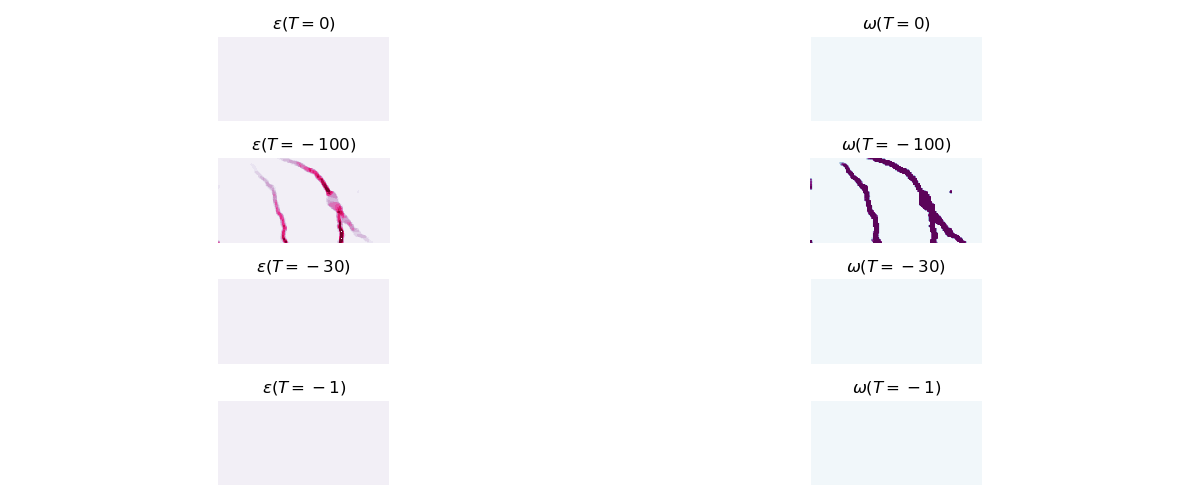

In [32]:
fig = plt.figure(figsize=(12,5), tight_layout=True)
fig.canvas.header_visible = False
T_selection = [0, -100, -30, -1]
rows = fig.subplots(len(T_selection), 2)
for (ax_eps, ax_omega), T in zip(rows, T_selection):
    ax_eps.contourf(X_aKL[0], X_aKL[1], kappa_TKL[T], cmap='PuRd', 
                    levels=np.linspace(0,0.05,15)) # , vmin=eps_0, vmax=50*eps_0,)
    ax_eps.axis('equal');
    ax_eps.axis('off');
    ax_eps.set_title(r'$\varepsilon(T={}$)'.format(T));
    ax_omega.contourf( X_aKL[0], X_aKL[1], omega_TKL[T], cmap='BuPu', levels=np.linspace(0,1,15))
#                      vmin=0, vmax=1)
    ax_omega.axis('equal');
    ax_omega.axis('off');
    ax_omega.set_title(r'$\omega(T={})$'.format(T));

In [33]:
eps_TKLa = eps_TEmFna.reshape(-1, n_E*n_m, n_F*n_n, n_a)

In [34]:
np.max(eps_TKLa)

3.53469401638905

In [35]:
eps_TKL_comp = np.copy(eps_TKLa[:, :, :, 1])
eps_TKL_comp[eps_TKL_comp>0] = 0
eps_TKL_comp[eps_TKLa[:, :, :, 0] > 0.005 ] = 0
eps_min_val = np.min(eps_TKL_comp)
eps_min_val

-0.012424284362294195

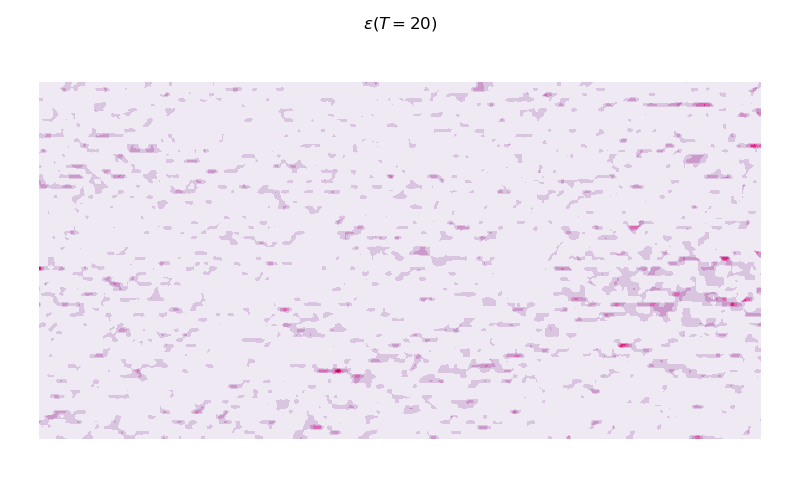

In [36]:
fig = plt.figure(figsize=(8,5), tight_layout=True)
fig.canvas.header_visible = False
T = 20
ax = fig.subplots(1,1)
ax.contourf(X_aKL[0], X_aKL[1], eps_TKL_comp[-1], cmap='PuRd_r'), 
#                    levels=np.linspace(0,1,10)) # , vmin=eps_0, vmax=50*eps_0,)
ax.axis('equal');
ax.axis('off');
ax.set_title(r'$\varepsilon(T={})$'.format(T));

In [ ]:
eps_TKLab = eps_TEmFnab.reshape(-1, n_E*n_m, n_F*n_n, n_a, n_a)
sig_TKLab = np.einsum(',...,...ab->...ab', 30000, (1 - omega_TKL), eps_TKLab)

In [ ]:
E_TKL = np.einsum('...ab,...ab->...', sig_TKLab, eps_TKLab) 

In [ ]:
np.max(E_TKL), np.min(E_TKL)

In [ ]:
fig = plt.figure(figsize=(8,5), tight_layout=True)

T = 20
ax = fig.subplots(1,1)
ax.contourf(X_aKL[0], X_aKL[1], E_TKL[T], cmap='PuRd'), 
#                    levels=np.linspace(0,1,10)) # , vmin=eps_0, vmax=50*eps_0,)
ax.axis('equal');
ax.axis('off');
ax.set_title(r'$E(T={})$'.format(T));